We do the neccessary imports

In [4]:
from qiskit.quantum_info import Statevector
from qiskit_ibm_runtime.fake_provider import FakeManilaV2

from qiskit.circuit.library import XGate, YGate
from qiskit.transpiler import InstructionProperties
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes.scheduling import (
    ALAPScheduleAnalysis,
    PadDynamicalDecoupling,
)

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from numpy import pi, sqrt, exp
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import QFT
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
import warnings

warnings.filterwarnings("ignore")

Now we have a **TrueQuantumBurgersSolver** class, which sets up the framework for simulating the 1D Burgers’ equation using a **quantum computing approach**. This initialization method configures both the **physical parameters** of the problem (viscosity, boundary conditions, spatial/temporal resolution) and the **quantum simulation settings** (number of qubits, measurement shots, quantum backend). The spatial grid is discretized into $2^{n\_qubits}$ points, and the solver is ready to run on a **Qiskit AerSimulator**, allowing experiments with Trotterized time evolution and quantum algorithms for partial differential equations. It prints a clear summary so the user knows exactly how the simulation is configured before execution.


In [5]:
class TrueQuantumBurgersSolver:
    def __init__(self, n_qubits=4, viscosity=0.01, T=0.05, dt=0.01, u_left=1.0, u_right=0.0, shots=4096):
        """
        Initialize solver parameters and grid.
        n_qubits : number of qubits (nx = 2**n_qubits grid points)
        viscosity: diffusion-like coefficient (used to design phases)
        T, dt   : final time and timestep
        u_left, u_right: Dirichlet boundary conditions
        shots   : simulator shots for measurements
        """
        self.n_qubits = int(n_qubits)
        self.nx = 2 ** self.n_qubits
        self.viscosity = float(viscosity)
        self.T = float(T)
        self.dt = float(dt)
        self.u_left = float(u_left)
        self.u_right = float(u_right)
        self.shots = int(shots)

        # spatial domain
        self.L = 1.0
        self.x = np.linspace(0.0, self.L, self.nx)
        self.dx = self.x[1] - self.x[0]

        # backend (AerSimulator)
        self.backend = AerSimulator()

        print("Initialized TrueQuantumBurgersSolver")
        print(f"  Qubits: {self.n_qubits}, grid points: {self.nx}")
        print(f"  viscosity={self.viscosity}, dt={self.dt}, T={self.T}")
        print(f"  BCs: u(0)={self.u_left} , u(1)={self.u_right}")
        print(f"  Shots per quantum execution: {self.shots}")
        print()


Now we introduce two key methods for preparing the **initial quantum state** of the Burgers’ equation simulation.

The `initial_condition_riemann` method sets up a **Riemann step** profile — a discontinuous field where the left half has velocity $u = 1.0$ and the right half $u = 0.0$, with boundary conditions enforced at the ends.

The `amplitude_encode` method then **maps this real-valued field into a quantum statevector**, ready for loading onto qubits. It ensures the amplitudes are non-negative for magnitude encoding, applies a **phase profile inspired by the Madelung transformation** (based on the cumulative sum of the field), pads or truncates to match $2^{n\_qubits}$ entries, and normalizes the vector to form a valid quantum state. This step bridges the **classical PDE representation** with the **quantum computational framework**.


In [8]:
def initial_condition_riemann(self):
        """Riemann step initial condition."""
        u0 = np.where(self.x <= 0.5, 1.0, 0.0)
        u0[0] = self.u_left
        u0[-1] = self.u_right
        return u0

def amplitude_encode(self, u_field):
        """
        Encode a real-valued field into a normalized complex amplitude vector.
        This uses the absolute values as densities and a simple phase proportional
        to the cumulative sum of u_field (Madelung transform-inspired ).
        """
        # avoid negatives for amplitude magnitudes by shifting
        nonneg = u_field - np.min(u_field)
        if np.allclose(nonneg, 0):
            mags = np.ones_like(nonneg) / len(nonneg)
        else:
            mags = nonneg / np.sum(nonneg)

        # phase: cumulative sum scaled to [-pi, pi]
        cumsum = np.cumsum(u_field) * self.dx
        if np.max(np.abs(cumsum)) < 1e-12:
            phases = np.zeros_like(cumsum)
        else:
            phases = (cumsum / np.max(np.abs(cumsum))) * pi

        amps = np.sqrt(mags) * np.exp(1j * phases)
        # make sure length matches 2**n_qubits
        if len(amps) < self.nx:
            padded = np.zeros(self.nx, dtype=complex)
            padded[: len(amps)] = amps
            amps = padded
        elif len(amps) > self.nx:
            amps = amps[: self.nx]

        # normalize
        norm = np.linalg.norm(amps)
        if norm < 1e-12:
            amps = np.zeros(self.nx, dtype=complex)
            amps[0] = 1.0
        else:
            amps /= norm

        return Statevector(amps)

Now we define the **build\_evolution\_circuit** method, which constructs a **hardware-friendly quantum circuit** to perform one **time evolution step** of the Burgers’ equation in a hybrid quantum–classical framework.

The approach follows a **split-operator style**:

* **Spectral step:** Apply a Quantum Fourier Transform (QFT) to move into momentum space, then implement **kinetic-phase rotations** (diffusion-like effects) based on $k^2$ scaling.
* **Inverse transform:** Use the inverse QFT to return to position space.
* **Nonlinear step:** Apply **position-dependent RZ rotations** proportional to the local velocity field $u(x)$, plus small **controlled-phase couplings** to mimic nonlinear interactions.
* **Measurement:** Read out all qubits for statistical estimation.

This circuit omits explicit state preparation (to keep the example clear) and instead assumes an amplitude-prepared statevector is evolved on the simulator. It is structured with barriers for clarity and is compatible with both simulators and real quantum hardware.


In [9]:
def build_evolution_circuit(self, u_field):
        """

        amplitude-prep circuits for demonstration.
        """
        qreg = QuantumRegister(self.n_qubits, "q")
        creg = ClassicalRegister(self.n_qubits, "c")
        qc = QuantumCircuit(qreg, creg, name="evolution_step")

        # QFT -> implement spectral (k-space) phases (diffusion-like)
        qc.append(QFT(self.n_qubits), qreg)
        qc.barrier()

        # Apply simple k-dependent RZ phases to mimic diffusion/kinetic term
        # Use mapping k = 2*pi*m/L (m from 0..nx-1 but wrap negative frequencies)
        for m in range(self.nx):
            # map m to frequency index for n_qubits bitwise; we only have n_qubits wires,
            # so use per-wire phases that are an inexpensive proxy.
            wire = m % self.n_qubits
            k = 2.0 * pi * m / self.L
            phase = -self.viscosity * (k ** 2) * self.dt
            qc.rz(phase, qreg[wire])

        qc.barrier()
        # inverse QFT
        qc.append(QFT(self.n_qubits).inverse(), qreg)
        qc.barrier()

        # position-space nonlinear "potential" rotations using local u_field
        # Map spatial points to qubit wires in a simple repeated manner
        for idx in range(self.nx):
            wire = idx % self.n_qubits
            angle = -u_field[idx] * self.dt
            qc.rz(angle, qreg[wire])
            # add small controlled-phase coupling between adjacent wires for nonlinearity
            if wire > 0:
                qc.crz(0.1 * angle, qreg[wire - 1], qreg[wire])

        qc.barrier()
        qc.measure(qreg, creg)
        return qc

Now we implement the run_quantum_execution method, which handles the actual execution of the quantum evolution step starting from a pre-prepared quantum statevector.

Instead of building a costly amplitude-preparation circuit, this method directly evolves the given initial_statevec by applying the circuit’s unitary part (with measurements temporarily removed). The resulting evolved state is converted into measurement probabilities, and classical sampling with a multinomial distribution is used to mimic running the circuit with a finite number of shots.

The method returns:

Counts dictionary → measurement outcomes and their frequencies.

Transpiled circuit → a hardware-optimized version of the evolution step for inspection or real backend execution.

This approach combines accuracy (statevector evolution avoids state-prep errors) with realistic sampling noise, making it ideal for quantum algorithm benchmarking.

In [10]:
def run_quantum_execution(self, initial_statevec, circuit):
        """
        Execute a circuit on AerSimulator *starting from an initial statevector*.
        Strategy:
          - Use Statevector to apply unitary (simulate state evolution) OR
          - Use AerSimulator with initialization instruction in a transpiled circuit.
             instruction; transpile + backend.run used for execution as reference)
        """
        # Path A: evolve statevector directly (preferred, avoids amplitude-prep)
        evolved_sv = initial_statevec.evolve(circuit.remove_final_measurements(inplace=False))
        # convert evolved state to probabilities and then sample using multinomial to mimic shots
        probs = np.abs(evolved_sv.data) ** 2
        probs = probs / np.sum(probs)

        # sample measurement outcomes according to probs
        outcomes = np.random.multinomial(self.shots, probs)
        counts = {}
        for idx, cnt in enumerate(outcomes):
            if cnt == 0:
                continue
            bitstr = format(idx, "b").zfill(self.n_qubits)
            counts[bitstr] = int(cnt)

        # Also return a transpiled circuit for inspection (transpile the circuit for backend)
        transpiled = transpile(circuit, self.backend)
        return counts, transpiled

Now we add the measurement decoding and quantum time-stepping components of the solver, which connect the raw quantum outputs back to the evolving classical field.

The measurements_to_field method takes quantum measurement counts (bitstring → frequency) and converts them into a velocity-like field:

Normalizes measurement counts into probabilities.

Maps probability variations into velocity estimates using a simple scaling model.

Blends the new estimate with the previous velocity field for stability.

Enforces boundary conditions, applies smoothing, and clips extreme values.

The quantum_time_step method performs one complete hybrid update:

Encoding: Convert the current velocity field into a quantum statevector.

Circuit building: Generate a hardware-friendly evolution circuit.

Execution: Simulate the circuit starting from the encoded state.

Decoding: Transform the quantum measurement outcomes back into a classical field.

Classical stabilization: Apply a small implicit diffusion correction based on viscosity.

In [13]:
def measurements_to_field(self, counts, u_prev):
        """
        Convert measurement counts (bitstring->count) into a velocity-like field.
        We map |psi|^2 -> density; then approximate a velocity update via finite differences
        on the density distribution, blended with the previous field for stability.
        """
        probs = np.zeros(self.nx)
        total = sum(counts.values()) if counts else 1
        for bitstr, c in counts.items():
            idx = int(bitstr, 2)
            if idx < self.nx:
                probs[idx] = c / total

        # small smoothing & ensure positivity
        probs = probs + 1e-12
        probs /= np.sum(probs)

        # Convert probability profile into a tentative velocity via simple scaling:
        # higher local density -> slightly higher velocity (toy model).
        vel_from_probs = (probs - np.min(probs)) / (np.max(probs) - np.min(probs) + 1e-12)
        vel_from_probs = vel_from_probs * (np.max(u_prev) - np.min(u_prev) + 1e-12) + np.min(u_prev)

        # blend with previous for stability
        blend_alpha = min(0.5, self.dt)  # small blending factor
        u_new = (1 - blend_alpha) * u_prev + blend_alpha * vel_from_probs

        # impose boundary conditions strongly
        u_new[0] = self.u_left
        u_new[-1] = self.u_right

        # small smoothing filter
        u_new[1:-1] = 0.5 * u_new[1:-1] + 0.25 * (u_new[0:-2] + u_new[2:])

        # clip to reasonable range
        u_new = np.clip(u_new, -5.0, 5.0)
        return u_new

def quantum_time_step(self, u_current):
        """Run one quantum time step: encode -> build circuit -> execute -> decode."""
        # encode
        sv = self.amplitude_encode(u_current)

        # build circuit (measurements included)
        qc = self.build_evolution_circuit(u_current)

        # execute on simulator starting from the amplitude-encoded state
        counts, transpiled = self.run_quantum_execution(sv, qc)

        # decode
        u_next = self.measurements_to_field(counts, u_current)

        # classical stabilization (very simple implicit diffusion-ish step)
        alpha = self.viscosity * self.dt / (self.dx ** 2)
        if alpha > 0.2:
            u_next[1:-1] = (u_next[1:-1] + alpha * (u_next[:-2] + u_next[2:])) / (1 + 2 * alpha)

        return u_next, transpiled, counts

Now we complete the TrueQuantumBurgersSolver workflow by adding the full time evolution loop and visualization tools.

The solve method orchestrates the simulation:

Initializes the velocity field with the Riemann step condition.

Iteratively runs quantum_time_step to advance the PDE in time.

Records time points, solution history, transpiled quantum circuits, and measurement counts.

Stops early if instability is detected.

Prints progress and a final execution summary.

The plot_solution method provides multiple ways to analyze results:

Snapshots plot — velocity profiles at selected time points.

Space–time contour — color map showing how
𝑢
(
𝑥
,
𝑡
)
u(x,t) evolves.

Optional entropy plot — if measurement counts are available, computes the Shannon entropy of quantum outcomes over time.

Finally, the __main__ block demonstrates usage:

Instantiates the solver with example parameters.

Evolves the system for a few steps.

Prints circuit statistics for each step.

Generates plots to visualize the quantum-influenced Burgers’ equation evolution.

In [ ]:
def solve(self, max_steps=None, verbose=True):
        """Evolve for T seconds (or limited by max_steps). Returns t_points, history, circuits, counts."""
        u = self.initial_condition_riemann()
        t_points = [0.0]
        u_hist = [u.copy()]
        circuit_list = []
        counts_list = []

        n_steps = int(np.ceil(self.T / self.dt))
        if max_steps is not None:
            n_steps = min(n_steps, max_steps)

        t = 0.0
        for step in range(n_steps):
            if verbose:
                print(f"Step {step+1}/{n_steps}  t={t:.4f}  max|u|={np.max(np.abs(u)):.6f}")
            u, transpiled, counts = self.quantum_time_step(u)
            t += self.dt
            t_points.append(t)
            u_hist.append(u.copy())
            circuit_list.append(transpiled)
            counts_list.append(counts)

            # simple stability break
            if np.isnan(np.max(u)) or np.max(np.abs(u)) > 1e3:
                print("Stability problem encountered; stopping early.")
                break

        if verbose:
            print("Quantum evolution finished.")
            print(f"Executed steps: {len(circuit_list)}")

        return np.array(t_points), np.array(u_hist), circuit_list, counts_list

def plot_solution(self, t_points, u_hist, counts_list=None):
        """Two-panel plot: snapshots and space-time contour. Optionally show entropy plot."""
        plt.figure(figsize=(12, 5))
        # snapshots
        n_snap = min(5, len(t_points))
        indices = np.linspace(0, len(t_points) - 1, n_snap, dtype=int)
        for idx in indices:
            plt.plot(self.x, u_hist[idx], label=f"t={t_points[idx]:.3f}", marker="o")
        plt.xlabel("x")
        plt.ylabel("u(x,t)")
        plt.title("True Quantum Burgers - snapshots")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # space-time contour
        plt.figure(figsize=(10, 5))
        X, T = np.meshgrid(self.x, t_points)
        plt.contourf(X, T, u_hist, levels=40, cmap="viridis")
        plt.colorbar(label="u(x,t)")
        plt.xlabel("x")
        plt.ylabel("t")
        plt.title("Space-time evolution (quantum-influenced)")
        plt.tight_layout()
        plt.show()

        # entropy from counts (if provided)
        if counts_list:
            entropies = []
            for counts in counts_list:
                total = sum(counts.values()) if counts else 1
                probs = np.array([c / total for c in counts.values()]) if counts else np.array([1.0])
                ent = -np.sum(probs * np.log2(probs + 1e-12))
                entropies.append(ent)
            plt.figure(figsize=(8, 3))
            plt.plot(t_points[1 : 1 + len(entropies)], entropies, "-o")
            plt.xlabel("t")
            plt.ylabel("Shannon entropy (bits)")
            plt.title("Measurement entropy over time")
            plt.grid(True)
            plt.tight_layout()
            plt.show()


if __name__ == "__main__":
    # Instantiate solver (example configuration)
    solver = TrueQuantumBurgersSolver(
        n_qubits=4,      # 16 grid points
        viscosity=0.01,
        T=0.05,
        dt=0.01,
        u_left=1.0,
        u_right=0.0,
        shots=4096,
    )

    # Run for a few steps (limit for demonstration)
    t_pts, u_hist, circuits, counts = solver.solve(max_steps=5, verbose=True)

    # Basic analysis prints
    print("\nSummary of executed quantum circuits:")
    for i, qc in enumerate(circuits):
        print(f" Step {i+1}: depth={qc.depth()}, gates={len(qc.data)}, distinct_outcomes={len(counts[i])}")

    # Plot results
    solver.plot_solution(t_pts, u_hist, counts)

Now we set up a **side-by-side comparison** between the quantum-enhanced Burgers’ equation solver and a purely classical baseline.

We first instantiate:

* `solver_q` — the full **TrueQuantumBurgersSolver**, which uses amplitude encoding, quantum circuit evolution, and measurement decoding.
* `solver_c` — a **ClassicalBurgersSolver** subclass that overrides the `quantum_time_step` method with a simple finite-difference smoothing step, effectively removing the quantum components.

Both solvers run for the same time horizon and number of steps. The results are:

* **Plotted** to compare the final velocity profiles from the quantum and classical evolutions.
* **Quantified** using the $L^2$ norm difference between their final states, providing a numerical measure of how much the quantum approach deviates from the classical one.

This snippet highlights how quantum simulation results can be directly benchmarked against classical methods for performance and accuracy evaluation.


Initialized TrueQuantumBurgersSolver
  Qubits: 4, grid points: 16
  viscosity=0.01, dt=0.01, T=0.1
  BCs: u(0)=1.0 , u(1)=0.0
  Shots per quantum execution: 4096

Initialized TrueQuantumBurgersSolver
  Qubits: 4, grid points: 16
  viscosity=0.01, dt=0.01, T=0.1
  BCs: u(0)=1.0 , u(1)=0.0
  Shots per quantum execution: 4096



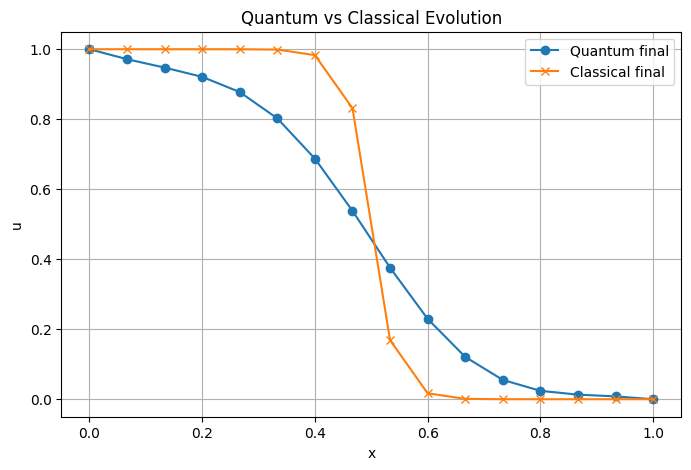

L2 difference between quantum and classical final states: 0.585842


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Instantiate quantum solver
solver_q = TrueQuantumBurgersSolver(
    n_qubits=4, viscosity=0.01, T=0.1, dt=0.01, u_left=1.0, u_right=0.0, shots=4096
)

# Instantiate a "classical version" by overriding the quantum step
class ClassicalBurgersSolver(TrueQuantumBurgersSolver):
    def quantum_time_step(self, u_current):
        # Simple classical smoothing + advection
        u_next = u_current.copy()
        alpha = self.viscosity * self.dt / (self.dx ** 2)
        u_next[1:-1] = (u_next[1:-1] +
                        alpha * (u_next[:-2] - 2 * u_next[1:-1] + u_next[2:]))
        return u_next, None, None

solver_c = ClassicalBurgersSolver(
    n_qubits=4, viscosity=0.01, T=0.1, dt=0.01, u_left=1.0, u_right=0.0
)

# Run both solvers
t_q, u_q, _, _ = solver_q.solve(max_steps=10, verbose=False)
t_c, u_c, _, _ = solver_c.solve(max_steps=10, verbose=False)

# Plot comparison
plt.figure(figsize=(8,5))
plt.plot(solver_q.x, u_q[-1], label="Quantum final", marker='o')
plt.plot(solver_c.x, u_c[-1], label="Classical final", marker='x')
plt.legend()
plt.xlabel("x")
plt.ylabel("u")
plt.title("Quantum vs Classical Evolution")
plt.grid(True)
plt.show()

# Print L2 difference
diff = np.linalg.norm(u_q[-1] - u_c[-1])
print(f"L2 difference between quantum and classical final states: {diff:.6f}")